# ETTm1에 대해서 수행

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE,MAE,RMSE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 모델 구성하기
* 이전과 다르게 sequence_length를 `4(15minutes*4)*24(24hours)*30(30days) = 2880` 즉 30일을 바라봄

In [2]:
hour_data = pd.read_csv('../../GeneralData/ETTh2.csv')
hour_data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
2,2016-07-01 02:00:00,37.946999,11.309,35.330002,9.007,2.100,0.000,36.465000
3,2016-07-01 03:00:00,38.952000,11.895,35.543999,9.436,3.380,1.215,33.608501
4,2016-07-01 04:00:00,38.113998,11.476,35.410000,9.623,2.036,0.000,31.850500
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,39.202999,11.392,49.644001,11.929,-10.331,-1.258,47.084999
17416,2018-06-26 16:00:00,38.113998,10.974,48.759998,11.366,-10.331,-1.290,48.183498
17417,2018-06-26 17:00:00,39.622002,10.974,50.609001,11.661,-11.557,-1.418,48.183498
17418,2018-06-26 18:00:00,43.643002,13.403,54.737000,13.778,-10.299,-1.418,46.865501


* minute data를 hour data와 비교했을때 누적이아닌 단순히 분단위로 추적했을 뿐이다.

In [3]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

In [4]:
data = pd.read_csv('../../GeneralData/ETTm2.csv')
sequence_length = 4*24*30 # 4*24*30 
pred_len = 1

## 2. Sequence중에 빈 시간이 없나 Check

In [5]:
import datetime as dt

In [6]:
data['date'] = pd.to_datetime(data['date'])
for i in range(data.shape[0]-1):
    if data['date'].iloc[i]+dt.timedelta(minutes = 15) == data['date'].iloc[i+1]: continue        
    else: print(i)

### &rightarrow; 빈시간 없음

In [7]:
data = data[['OT']]

In [8]:
data

,OT
0,38.661999
1,38.223000
2,37.344002
3,37.124001
4,37.124001
...,...
69675,45.986500
69676,45.986500
69677,45.546501
69678,45.546501


<AxesSubplot: >

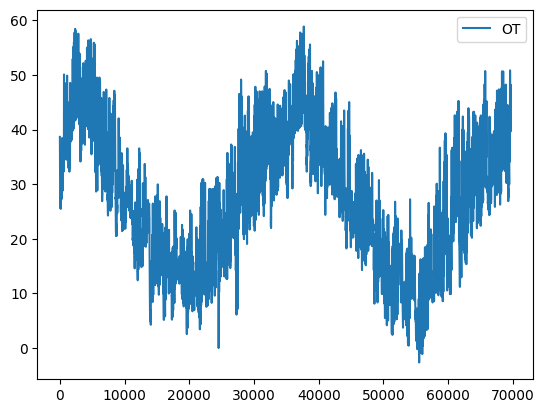

In [9]:
data.plot()

In [10]:
from torch import FloatTensor as FloatTensor

In [11]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length-pred_len):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [12]:
split = 24*7 # 24시간 x 7로써 1주일을 테스트셋으로 만듦

In [13]:
seed = 42

In [14]:
device = torch.device("cuda:0")

In [15]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 1
        self.train_index = train_index
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        return self.first_layer(x[:,:,self.train_index]) 

# 3. Train-Validation set으로 쪼개기

In [16]:
data

,OT
0,38.661999
1,38.223000
2,37.344002
3,37.124001
4,37.124001
...,...
69675,45.986500
69676,45.986500
69677,45.546501
69678,45.546501


* 69680개 중 일주일치 데이터인 672개의 데이터를 Test Set
* 69008개 중 0.2의 비율인 13802개는 validation set
* 69008개 중 0.8의 비율인 55206개는 train set

In [17]:
val_num = 13802

In [18]:
train = data.iloc[:-split-val_num]
val = data.iloc[-split-val_num:-split]
x_train,y_train = seq_data(train, sequence_length = sequence_length, pred_len = pred_len)
x_val,y_val = seq_data(val, sequence_length = sequence_length, pred_len = pred_len)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_793484/4291513198.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [19]:
next(iter(validation))[0].size()

torch.Size([64, 1, 2880])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [20]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(sequence_length)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = SMAPE()
num_epochs = 100
n= len(training)

### 기본 모델 training

In [21]:
import copy

In [22]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        
        outputs = outputs.view(-1,1)
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[100] running accumulative loss across all batches: 3872.310
changed
changed
changed
changed
changed
changed
Epoch [21]/[100] running accumulative loss across all batches: 546.088
changed
changed
Epoch [41]/[100] running accumulative loss across all batches: 837.869
changed
Epoch [61]/[100] running accumulative loss across all batches: 2160.294
Epoch [81]/[100] running accumulative loss across all batches: 509.112


### validation set에 대해서 attribution 구하기

In [23]:
n = len(validation)
n

171

In [24]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((1,sequence_length))
for val in validation:
    temp_n = val[0].size(0)
    temp = nt_ig.attribute(val[0]).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음
    nt_ig_attr_score = nt_ig_attr_score.to(device)+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [25]:
len(nt_ig_attr_score)

2880

<AxesSubplot: >

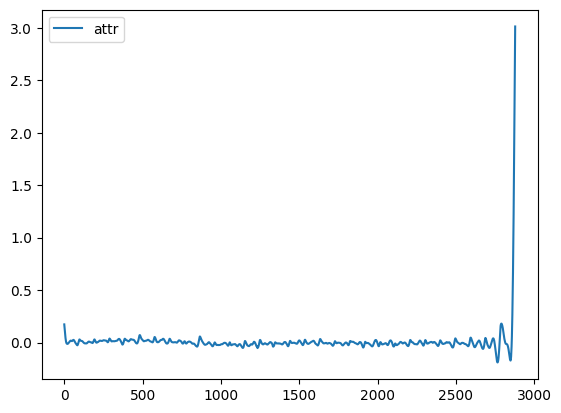

In [26]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

<AxesSubplot: >

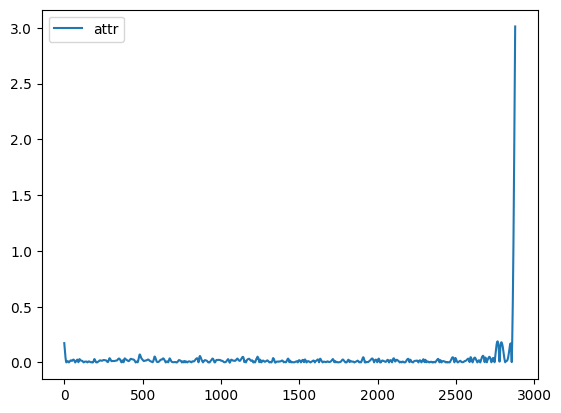

In [27]:
attr_df = attr_df.abs()
attr_df.plot()

### &rightarrow; 최근데이터가 매우강조 되는것을 확인할 수 있다.

#### scaling

In [28]:
IQR = 1.5*(attr_df.quantile(0.75)-attr_df.quantile(0.25))
outlier_max = attr_df.quantile(0.75)+IQR
outlier_min = attr_df.quantile(0.25)-IQR
candidate_attr = attr_df[(attr_df>=outlier_min) & (attr_df<=outlier_max)]
candidate_attr = candidate_attr.dropna()
candidate_attr

,attr
8,0.043006
9,0.031024
10,0.020638
11,0.011807
12,0.004399
...,...
2832,0.032189
2833,0.037713
2834,0.043930
2856,0.038429


<AxesSubplot: >

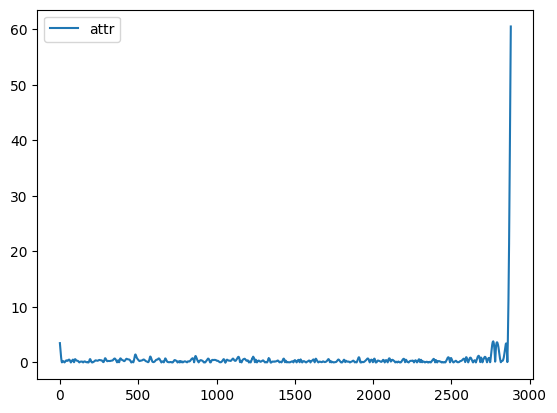

In [29]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
scaler.fit(candidate_attr.values)
m_attr_df = scaler.transform(attr_df.values)
m_attr_df = pd.DataFrame({"attr":m_attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
m_attr_df.plot()

In [30]:
m_attr_df.describe()

,attr
count,2880.000000
mean,0.573869
std,2.809463
min,0.000000
25%,0.122016
50%,0.279147
75%,0.473547
max,60.483097


<AxesSubplot: >

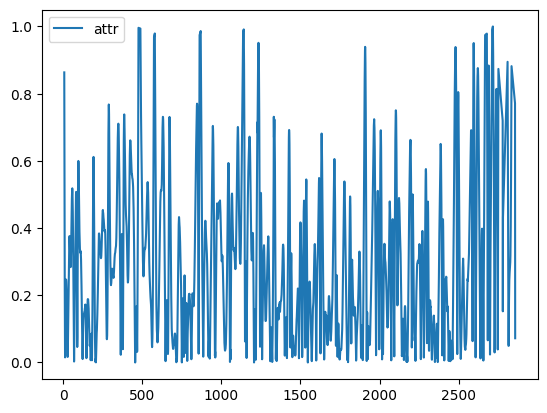

In [31]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna().plot()

<AxesSubplot: >

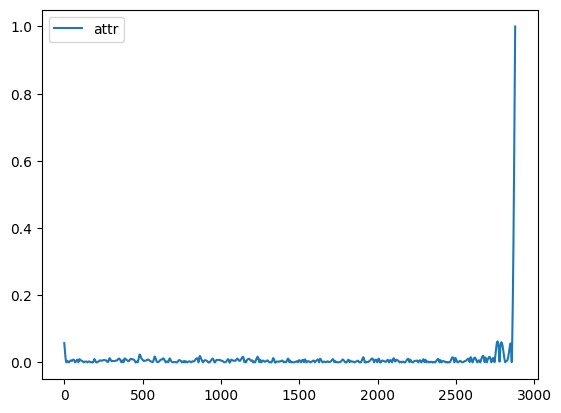

In [32]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
attr_df.plot()

#### train_index구하기

In [33]:
index_list = []

for hyper_para in np.arange(0.00,1.01,0.01):
    append_idx = list(m_attr_df[(m_attr_df['attr']>=hyper_para)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

101

In [34]:
len_list=[]
for i in range(100):
    len_list.append(len(index_list[i]))


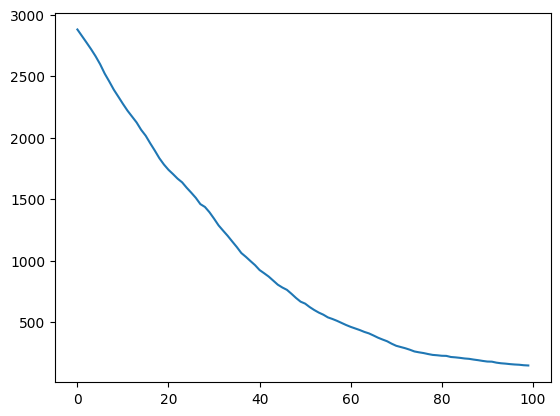

In [35]:
plt.plot(np.arange(100),len_list) # 포함되는 time_index의 갯수

In [36]:
for val_x,val_y in validation:
    print(val_x,val_y)

tensor([[[-0.8885, -0.8885, -0.8885,  ..., 14.7120, 14.7120, 14.7120]],

        [[-0.8885, -0.8885, -0.6690,  ..., 14.7120, 14.7120, 14.7120]],

        [[-0.8885, -0.6690, -0.2295,  ..., 14.7120, 14.7120, 14.9315]],

        ...,

        [[ 6.5820,  6.5820,  6.5820,  ..., 22.6220, 22.4020, 22.4020]],

        [[ 6.5820,  6.5820,  6.5820,  ..., 22.4020, 22.4020, 22.1825]],

        [[ 6.5820,  6.5820,  6.5820,  ..., 22.4020, 22.1825, 22.1825]]],
       device='cuda:0') tensor([[[14.7120]],

        [[14.9315]],

        [[14.9315]],

        [[14.9315]],

        [[14.9315]],

        [[14.9315]],

        [[15.1515]],

        [[15.3715]],

        [[15.8105]],

        [[16.0300]],

        [[16.2500]],

        [[16.6895]],

        [[17.1285]],

        [[17.7880]],

        [[18.4475]],

        [[19.1065]],

        [[19.9855]],

        [[20.8645]],

        [[22.1825]],

        [[23.0615]],

        [[23.7210]],

        [[24.6000]],

        [[25.0390]],

        [[25.4785]

       device='cuda:0') tensor([[[14.4920]],

        [[15.3710]],

        [[15.8110]],

        [[16.2500]],

        [[17.1290]],

        [[17.5680]],

        [[18.4470]],

        [[19.3260]],

        [[20.2050]],

        [[21.5230]],

        [[22.8420]],

        [[24.1600]],

        [[25.2590]],

        [[26.3575]],

        [[27.2360]],

        [[27.8955]],

        [[28.7740]],

        [[29.4335]],

        [[30.3125]],

        [[30.9720]],

        [[31.1915]],

        [[31.6310]],

        [[32.2900]],

        [[33.1685]],

        [[33.8280]],

        [[34.0480]],

        [[34.7070]],

        [[35.3660]],

        [[35.8055]],

        [[36.0250]],

        [[36.2450]],

        [[36.2450]],

        [[36.0250]],

        [[35.5855]],

        [[35.1465]],

        [[34.7070]],

        [[34.2675]],

        [[33.3890]],

        [[32.7295]],

        [[32.0700]],

        [[31.4110]],

        [[30.7515]],

        [[30.0925]],

        [[29.6535]],

        

       device='cuda:0') tensor([[[23.0370]],

        [[23.0370]],

        [[23.2565]],

        [[23.2565]],

        [[23.2565]],

        [[23.2565]],

        [[23.2565]],

        [[23.2565]],

        [[23.2565]],

        [[23.2565]],

        [[23.2565]],

        [[23.2565]],

        [[23.2565]],

        [[23.2565]],

        [[23.0370]],

        [[23.0370]],

        [[23.0370]],

        [[22.8175]],

        [[22.8175]],

        [[22.8175]],

        [[22.5980]],

        [[22.5980]],

        [[22.5980]],

        [[22.5980]],

        [[22.5980]],

        [[22.3780]],

        [[22.3780]],

        [[22.1580]],

        [[21.7190]],

        [[20.8400]],

        [[19.9610]],

        [[19.3020]],

        [[18.8620]],

        [[18.4230]],

        [[18.2030]],

        [[17.9835]],

        [[17.7640]],

        [[17.7640]],

        [[17.3240]],

        [[17.3240]],

        [[17.3240]],

        [[17.3240]],

        [[17.7640]],

        [[18.6425]],

        

       device='cuda:0') tensor([[[41.2745]],

        [[40.6155]],

        [[40.1755]],

        [[39.5165]],

        [[39.2965]],

        [[38.8575]],

        [[38.1980]],

        [[37.9785]],

        [[37.9785]],

        [[37.5390]],

        [[37.3195]],

        [[36.8795]],

        [[36.4405]],

        [[36.0010]],

        [[35.3420]],

        [[34.6825]],

        [[33.8035]],

        [[33.3645]],

        [[32.9245]],

        [[32.4855]],

        [[31.8260]],

        [[31.1670]],

        [[30.7275]],

        [[30.2880]],

        [[30.0685]],

        [[29.6290]],

        [[29.4095]],

        [[28.9695]],

        [[28.7500]],

        [[28.5305]],

        [[28.0905]],

        [[28.0905]],

        [[27.6515]],

        [[27.6515]],

        [[27.2120]],

        [[27.2120]],

        [[26.7725]],

        [[26.7725]],

        [[26.3330]],

        [[25.8935]],

        [[25.8935]],

        [[25.8935]],

        [[25.4545]],

        [[25.4545]],

        

       device='cuda:0') tensor([[[26.9680]],

        [[27.4070]],

        [[27.8470]],

        [[28.5055]],

        [[28.9455]],

        [[29.6045]],

        [[30.2635]],

        [[30.9230]],

        [[31.5820]],

        [[32.2410]],

        [[32.4610]],

        [[32.4610]],

        [[32.4610]],

        [[32.2410]],

        [[31.5820]],

        [[31.3620]],

        [[31.3620]],

        [[31.5820]],

        [[31.8020]],

        [[32.4610]],

        [[33.5595]],

        [[34.8780]],

        [[35.9765]],

        [[36.6355]],

        [[37.0755]],

        [[37.7340]],

        [[38.3935]],

        [[38.8330]],

        [[39.2725]],

        [[39.4925]],

        [[39.4925]],

        [[39.0525]],

        [[38.8330]],

        [[38.1735]],

        [[37.7345]],

        [[37.5145]],

        [[37.2950]],

        [[36.8555]],

        [[36.6355]],

        [[36.1965]],

        [[35.9765]],

        [[35.9765]],

        [[35.5370]],

        [[35.5370]],

        

       device='cuda:0') tensor([[[38.1250]],

        [[38.1250]],

        [[37.6860]],

        [[37.6860]],

        [[37.2460]],

        [[37.2460]],

        [[36.8070]],

        [[36.8070]],

        [[36.5870]],

        [[36.3670]],

        [[36.3670]],

        [[36.1475]],

        [[35.9280]],

        [[35.7080]],

        [[35.4880]],

        [[35.2685]],

        [[35.0490]],

        [[34.8290]],

        [[34.8290]],

        [[34.6090]],

        [[34.6090]],

        [[34.1700]],

        [[34.1700]],

        [[34.1700]],

        [[33.9500]],

        [[33.7300]],

        [[33.7300]],

        [[33.7300]],

        [[33.7300]],

        [[33.9500]],

        [[34.1700]],

        [[34.6090]],

        [[35.0490]],

        [[35.4880]],

        [[36.1475]],

        [[36.8065]],

        [[37.4660]],

        [[38.1250]],

        [[38.7840]],

        [[39.6630]],

        [[40.5420]],

        [[41.2015]],

        [[41.8605]],

        [[42.7395]],

        

In [37]:
val_x

tensor([[[33.7790, 33.5595, 33.3400,  ..., 38.5400, 38.3205, 38.3205]],

        [[33.5595, 33.3400, 33.1200,  ..., 38.3205, 38.3205, 38.3205]],

        [[33.3400, 33.1200, 33.1200,  ..., 38.3205, 38.3205, 38.5400]],

        ...,

        [[26.7480, 26.7480, 26.7480,  ..., 35.4640, 35.4640, 35.4640]],

        [[26.7480, 26.7480, 26.7480,  ..., 35.4640, 35.4640, 35.4640]],

        [[26.7480, 26.7480, 26.9675,  ..., 35.4640, 35.4640, 35.4640]]],
       device='cuda:0')

In [ ]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
num_epochs = 100
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=np.inf
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

changed
changed
changed
changed
changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:751.6299579409797
changed
changed
changed
changed
changed
changed
changed
changed
1번째 모델 Training 완료 마지막 Epoch loss:8154.24848011634
changed
changed
changed
changed
changed
changed
changed
changed
2번째 모델 Training 완료 마지막 Epoch loss:1936.0456555166234
changed
changed
changed
changed
changed
changed
changed
changed
3번째 모델 Training 완료 마지막 Epoch loss:1184.3128568513125
changed
changed
changed
changed
changed
changed
changed
changed
changed
4번째 모델 Training 완료 마지막 Epoch loss:3925.3500382309967
changed
changed
changed
changed
changed
changed
changed
changed
changed
5번째 모델 Training 완료 마지막 Epoch loss:1695.032196176254
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
6번째 모델 Training 완료 마지막 Epoch loss:335.82155287049295
changed
changed
changed
changed
changed
changed
changed
changed
changed
7번째 모델 Training 완료 마지막 Epoch loss:1476.4011103001403
changed
changed
chan

changed
changed
changed
changed
changed
changed
changed
changed
41번째 모델 Training 완료 마지막 Epoch loss:75.17027944894666
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
42번째 모델 Training 완료 마지막 Epoch loss:200.65320597704473
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
chang

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
51번째 모델 Training 완료 마지막 Epoch loss:62.6898059213295
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
52번째 모델 Training 완료 

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
61번째 모델 Training 완료 마지막 Epoch loss:41.65716654740581
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

In [51]:
val_y # 다음 예측 타겟값

tensor([[[38.3205]],

        [[38.5400]],

        [[38.5400]],

        [[38.7600]],

        [[38.9795]],

        [[38.9795]],

        [[38.7595]],

        [[38.5400]],

        [[38.5400]],

        [[38.1010]],

        [[38.1010]],

        [[38.1010]],

        [[38.1010]],

        [[37.6610]],

        [[37.6610]],

        [[37.2220]],

        [[37.2220]],

        [[36.7820]],

        [[36.7820]],

        [[36.7820]],

        [[36.7820]],

        [[36.3430]],

        [[36.3430]],

        [[36.1230]],

        [[35.9030]],

        [[35.9030]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.4640]],

        [[35.0240]]], device='cuda:0')

In [52]:
val_x # 예측 하는 값

tensor([[[33.7790, 33.5595, 33.3400,  ..., 38.5400, 38.3205, 38.3205]],

        [[33.5595, 33.3400, 33.1200,  ..., 38.3205, 38.3205, 38.3205]],

        [[33.3400, 33.1200, 33.1200,  ..., 38.3205, 38.3205, 38.5400]],

        ...,

        [[26.7480, 26.7480, 26.7480,  ..., 35.4640, 35.4640, 35.4640]],

        [[26.7480, 26.7480, 26.7480,  ..., 35.4640, 35.4640, 35.4640]],

        [[26.7480, 26.7480, 26.9675,  ..., 35.4640, 35.4640, 35.4640]]],
       device='cuda:0')

In [53]:
val_x.size()

torch.Size([41, 1, 2880])

          out
100  0.407299


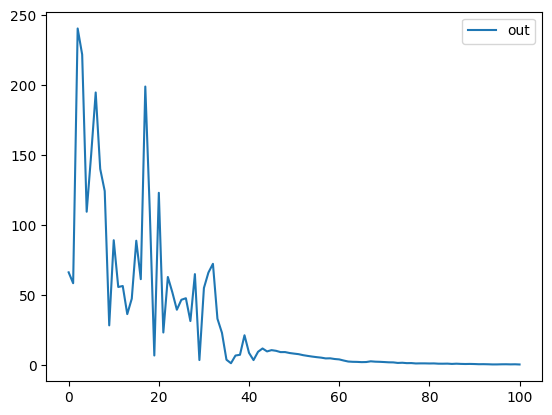

In [54]:
out_df = pd.DataFrame({"out":mse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [55]:
out_df

,out
0,66.288048
1,58.503536
2,240.640182
3,221.995789
4,109.618668
...,...
96,0.535569
97,0.562922
98,0.482816
99,0.541260


          out
100  0.531479


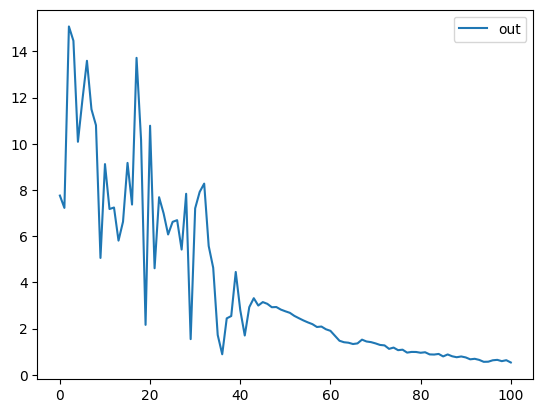

In [56]:
out_df = pd.DataFrame({"out":mae_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [57]:
out_df

,out
0,7.755166
1,7.221766
2,15.074110
3,14.455417
4,10.083565
...,...
96,0.626536
97,0.644757
98,0.589008
99,0.630278


          out
100  1.898323


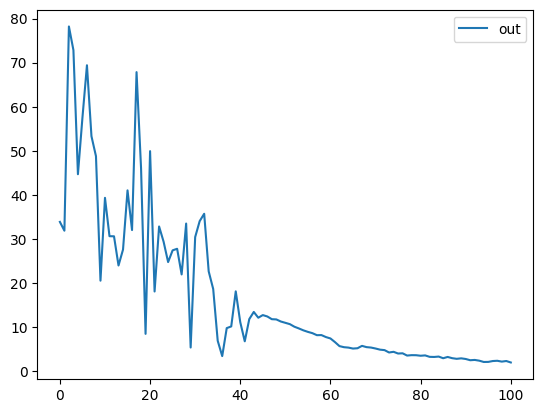

In [58]:
out_df = pd.DataFrame({"out":smape_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [59]:
out_df

,out
0,33.830035
1,31.832793
2,78.220677
3,72.848433
4,44.660285
...,...
96,2.226212
97,2.285346
98,2.095552
99,2.230948


        out
100  0.6382


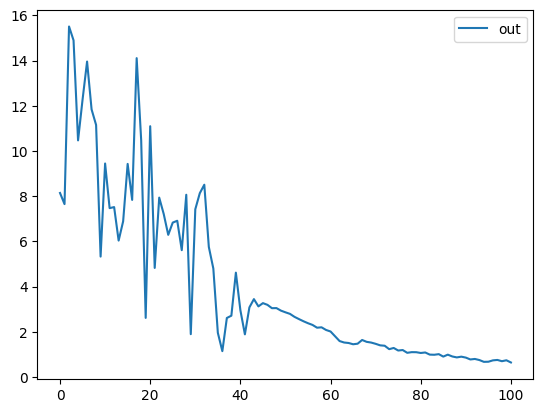

In [60]:
out_df = pd.DataFrame({"out":rmse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [61]:
out_df

,out
0,8.141747
1,7.648760
2,15.512582
3,14.899523
4,10.469893
...,...
96,0.731826
97,0.750281
98,0.694850
99,0.735704


In [62]:
attr_df.describe()

,attr
count,2880.000000
mean,0.009488
std,0.046450
min,0.000000
25%,0.002017
50%,0.004615
75%,0.007829
max,1.000000
